In [152]:
%reset -f

In [153]:
import pandas as pd
import numpy as np

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./sales.csv')
df.dropna(subset=['price'], inplace=True)
df.head()

df['year'] = pd.to_datetime(df.purchase_date).dt.year


In [154]:
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.pca_features = ['height', 'depth', 'width']
        self.pca = PCA(n_components=2)

    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        df['year'] = X['year']
        self.median = df.median(skipna=True)
        df = df.fillna(self.median)
        numeric_data_pca = df[self.pca_features]
        numeric_data_pca_scaled = StandardScaler().fit_transform(numeric_data_pca)
        self.pca.fit(numeric_data_pca_scaled)
        return self

    def transform(self, X):
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        df['year'] = X['year']
#        df['cost'] = df['cost'].fillna(90000)
        df = df.fillna(self.median)
        numeric_data_pca = df[self.pca_features]
        numeric_data_pca_scaled = StandardScaler().fit_transform(numeric_data_pca)
        pca_result = self.pca.transform(numeric_data_pca_scaled)
        pca_columns = [f'PCA_{i+1}' for i in range(pca_result.shape[1])]
        pca_df = pd.DataFrame(pca_result, columns=pca_columns)
        df = pd.concat([df, pca_df], axis=1)
        columns_to_remove = ['height', 'width', 'depth', 'volume']
        df = df.drop(columns=columns_to_remove)
        X['ingredient']=X['ingredient'].fillna('unknown')
        df['IngredientCounts'] = X['ingredient'].apply(self.count_ingredients)
        return df

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def weight2num(self, x):
        if pd.notnull(x):
            if 'Ton' in x:
                try:
                    return float(x.split(' Ton')[0]) * 1000
                except ValueError:
                    return np.nan
            else:
                try:
                    return float(x.strip('Kg'))
                except ValueError:
                    return np.nan
        return x

    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x) * 100
        else:
            return x

    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x

    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x

    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x) * 1000
        else:
            return x
    def count_ingredients(self, x):
        if x:
            ingredients_list = x.split(',')
            return len(ingredients_list)
        else:
            return 0

In [155]:
def price2num(x):
    if type(x) == str: 
        x = x.strip('$').replace(',', '')
    return float(x)

df['price']=df['price'].map(price2num)

In [156]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

numeric_features_lr = ['cost','weight', 'height', 'width', 'depth', 'year','ingredient']
categorical_features_lr = ['product_level', 'product_type', 'maker']
target=['price']

X_train = train_raw[numeric_features_lr]
y_train = train_raw[target]

X_test = test_raw[numeric_features_lr]
y_test = test_raw[target]


ctf=DataTransformer()
test=ctf.fit_transform(X_train)
test

,cost,weight,year,PCA_1,PCA_2,IngredientCounts
0,333000.0,3000.0,2008,-0.624547,0.170712,2
1,122000.0,3000.0,1997,-0.332048,-0.041000,5
2,270000.0,3000.0,2001,-2.339102,0.072643,3
3,97000.0,2000.0,2000,0.400974,-0.460660,3
4,59000.0,2000.0,2011,-1.024211,-0.336297,6
...,...,...,...,...,...,...
2752,254000.0,3000.0,2012,4.195146,0.089157,13
2753,91000.0,2000.0,2002,0.084287,-0.437410,8
2754,122000.0,2000.0,2007,2.387389,-0.543520,6
2755,44000.0,2000.0,2002,0.191032,-0.372078,1


In [157]:
numeric_features = ['cost', 'weight', 'height', 'width', 'depth', 'year','ingredient']
categorical_features = ['product_type']
target=['price']

X_train = train_raw[numeric_features + categorical_features ]
y_train = train_raw[target]

X_test = test_raw[numeric_features + categorical_features]
y_test = test_raw[target]

In [158]:
model = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('numeric', DataTransformer(), numeric_features),  # Include 'cost' in the numeric features
            ('categorical', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)  # Produce dense matrix
        ],
        remainder='drop'
    )),
    ('xgbr', XGBRegressor(max_depth=3,learning_rate=0.05,n_estimators=100,reg_lambda=0.1, min_child_weight=3))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', DataTransformer(),
                                                  ['cost', 'weight', 'height',
                                                   'width', 'depth', 'year',
                                                   'ingredient']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['product_type'])])),
                ('xgbr',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [150]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 9.25e+04
train MSE: 1.92e+10
train R2: 0.550
test MAE: 1.16e+05
test MSE: 4.12e+10
test R2: 0.522


In [151]:
feature_importances = model.named_steps['xgbr'].feature_importances_

# Display feature importances
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

cost: 0.3514259457588196
weight: 0.0
height: 0.015733206644654274
width: 0.026261454448103905
depth: 0.041531115770339966
year: 0.06071038544178009
ingredient: 0.0
product_type: 0.0


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

parameters = {
              'xgbr__gamma': [0.0, 0.1, 0.2, 0.3], 
              'xgbr__learning_rate': [0.05, 0.1], 
              'xgbr__n_estimators': [100, 300, 500], 
              'xgbr__max_depth': [3, 5, 10], 
              'xgbr__lambda': [0.5, 1, 5], 
              'xgbr__min_child_weight': [3, 5, 7]
             }
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('numeric', DataTransformer(), numeric_features),  # Include 'cost' in the numeric features
            ('categorical', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)  # Produce dense matrix
        ],
        remainder='drop'
    )),
    ('xgbr', XGBRegressor())# max_depth=3,learning_rate=0.05,n_estimators=100,reg_lambda=0.1, min_child_weight=3))
])

In [ ]:
model_gsv = GridSearchCV(model, parameters, cv = 5, scoring = scorer)
model_gsv = model_gsv.fit(X_train, y_train)
model_gsv.best_params_

In [12]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 9.29e+04
train MSE: 1.95e+10
train R2: 0.543
test MAE: 1.16e+05
test MSE: 4.13e+10
test R2: 0.521


Text(0, 0.5, 'y_test_pred')

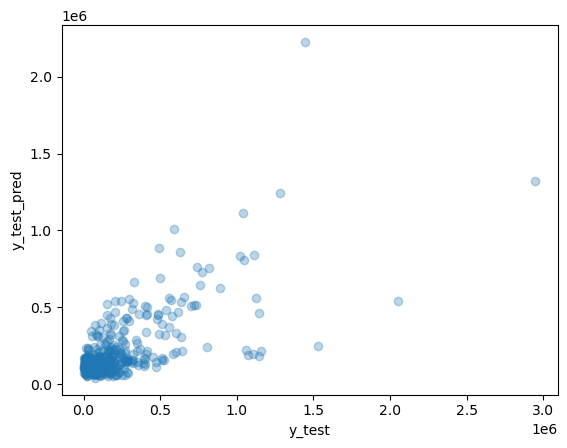

In [13]:
import matplotlib.pylab as plt

plt.scatter(y_test, model.predict(X_test), alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

Text(0, 0.5, 'y_train_pred')

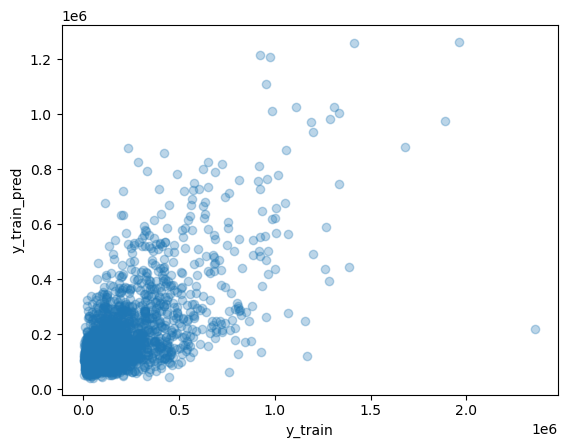

In [14]:
plt.scatter(y_train, model.predict(X_train), alpha = 0.3)
plt.xlabel('y_train')
plt.ylabel('y_train_pred')